In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk

/Users/macintosh/Library/Python/3.9/lib/python/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
test = pd.read_csv('./test.csv', index_col='id')
train = pd.read_csv('./train.csv', index_col='id')

In [5]:
train

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


0    4342
1    3271
Name: target, dtype: int64


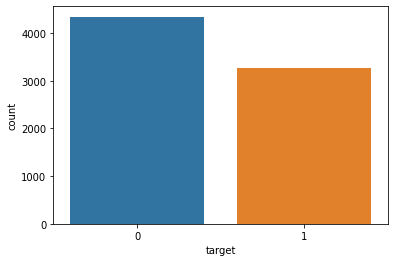

In [6]:
sns.countplot(x=train.target)
print(train.target.value_counts())

In [7]:
y=train.target

## Cleaning the text ##

In [8]:
def clean_text(text):
    #Make text lowercase, remove text in square brackets,remove links,remove punctuation
    #and remove words containing numbers
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [9]:
train.text = train.text.apply(clean_text)
test.text = test.text.apply(clean_text)

In [10]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [11]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'û', 'ï','ûò']
stop_words = stop_words + more_stopwords

In [12]:
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [13]:
train.text = train.text.apply(remove_stopwords)
test.text = test.text.apply(remove_stopwords)

In [14]:
from nltk import SnowballStemmer

In [15]:
stemmer = nltk.SnowballStemmer("english")

In [16]:
def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [17]:
train.text = train.text.apply(stemm_text)
test.text = test.text.apply(stemm_text)

## Creating a dictionary for the text ##

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer

In [19]:
tfidf = TfidfVectorizer()
train_vector = tfidf.fit_transform(train.text)
X_test =tfidf.transform(test.text)

In [28]:
len(tfidf.vocabulary_)

13489

In [21]:
train_vector.todense().shape

(7613, 13489)

In [26]:
train_vector.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

# Train Test Split #

In [23]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(train_vector, y, test_size=0.1, random_state=42)

# Model NN (in progress) # 

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, GRU, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras import regularizers

2023-10-20 09:49:41.005404: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
[2**i for i in range(0,15)]

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]

In [35]:
vocab_size = len(tfidf.vocabulary_)
embed_dim = 512
rnn_neurons = 1000
batch_size = 128

In [105]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=0)

In [109]:
model = Sequential()

model.add(Embedding(vocab_size, embed_dim))#,batch_input_shape=[batch_size, None]))
#model.add(GRU(rnn_neurons))
model.add(GlobalAveragePooling1D())
#model.add(GRU(rnn_neurons,return_sequences=True,stateful=True,recurrent_initializer='glorot_uniform'))
    # Final Dense Layer to Predict
model.add(Dense(vocab_size, activation='relu'))#,kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)))
model.add(BatchNormalization(synchronized=True))
model.add(Dropout(0.2))
model.add(Dense(5000, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

In [97]:
vocab_size

13489

In [110]:
model.fit(X_train.toarray(), y_train,
         validation_data=[X_valid.toarray(),y_valid],
         epochs=20,
         verbose=1,
         batch_size = 40,
         callbacks=[early_stop])

Epoch 1/20


<AxesSubplot:>

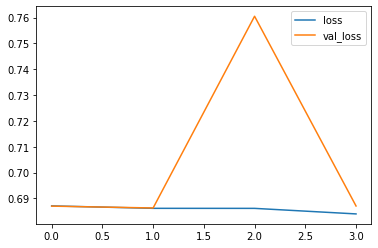

In [99]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()

In [103]:
 model.predict(X_valid)

24/24 [==============================] - 8s 327ms/step


array([[0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253946],
       [0.46253946],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.46253943],
       [0.462

24/24 [==============================] - 5s 187ms/step
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       426
           1       0.00      0.00      0.00       336

    accuracy                           0.56       762
   macro avg       0.28      0.50      0.36       762
weighted avg       0.31      0.56      0.40       762



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

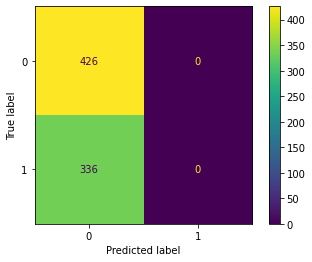

In [100]:
report(model, X_valid.toarray())

## Report of the model ##

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [74]:
def report(model, X_valid):
    #preds = model.predict(X_valid)
    preds = (model.predict(X_valid) > 0.5).astype('int32')
    print(classification_report(y_valid,preds))
    matrix = confusion_matrix(y_pred=preds, y_true=y_valid,)
    dis = ConfusionMatrixDisplay(confusion_matrix=matrix)
    dis.plot()
    plt.show()

# Model Naive Bayes Classification #

In [51]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train,y_train)

MultinomialNB()

              precision    recall  f1-score   support

           0       0.76      0.89      0.82       426
           1       0.82      0.65      0.73       336

    accuracy                           0.78       762
   macro avg       0.79      0.77      0.77       762
weighted avg       0.79      0.78      0.78       762



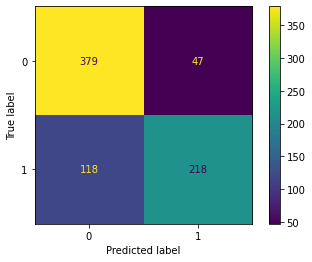

In [76]:
report(nb, X_valid)

In [53]:
prediction_nb = nb.predict(X_test)

In [54]:
submission = pd.DataFrame(data=prediction_nb, index=test.index, columns=['target'])

In [55]:
submission.to_csv('submission.csv')

# Model Random Forest #

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
RFmodel = RandomForestClassifier()

In [58]:
RFmodel=RandomForestClassifier(n_estimators=300, max_features='sqrt',criterion='gini')
RFmodel.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300)

              precision    recall  f1-score   support

           0       0.75      0.88      0.81       426
           1       0.81      0.63      0.71       336

    accuracy                           0.77       762
   macro avg       0.78      0.76      0.76       762
weighted avg       0.78      0.77      0.77       762



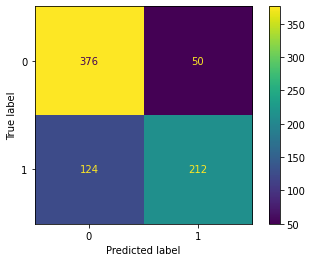

In [77]:
report(RFmodel, X_valid)

In [60]:
prediction_RF_result = RFmodel.predict(X_test)

In [61]:
pd.DataFrame(data=prediction_RF_result, index=test.index, columns=['target'])

,target
id,
0,1
2,1
3,1
9,1
11,1
...,...
10861,1
10865,1
10868,1
